In [1]:
#import libaries
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
input_band_3_b = 'image_data/band_3_before_flood.jp2'
input_band_11_b = 'image_data/band_11_before_flood.jp2'
input_scl_b = 'image_data/scl_image_before_flood.jp2'

input_band_3_f = 'image_data/band_3_during_flood.jp2'
input_band_11_f = 'image_data/band_11_during_flood.jp2'
input_scl_f = 'image_data/scl_image_during_flood.jp2'

In [3]:
def open(raster):
    with rasterio.open(raster) as src:
        raster = src.read(1)
    return raster


In [4]:
#Get CRS and transformation data
with rasterio.open(input_scl_f) as src:
    crs = src.crs
    transform = src.transform

band_green_b= open(input_band_3_b)
band_swir_b = open(input_band_11_b)
scl_b = open(input_scl_b)

band_green_f = open(input_band_3_f)
band_swir_f = open(input_band_11_f)
scl_f = open(input_scl_f)

In [5]:
def normalize(band_green, band_swir):
    #Calculate maximum values for each raster file
    max_value = band_green.max()
    max_value = band_swir.max()

    #Normalize raster data to 0-255 scale
    scaled_band_green = (band_green / max_value) * 255
    scaled_band_swir = (band_swir/ max_value) * 255

    return scaled_band_green, scaled_band_swir


In [6]:
#Calculate MNDWI value for given images
def mndwi(scaled_band_green, scaled_band_swir):
    mndwi = (scaled_band_green - scaled_band_swir) / (scaled_band_green + scaled_band_swir)
    return mndwi

In [7]:
band_green_b, band_swir_b = normalize(band_green_b, band_swir_b)
band_green_f, band_swir_f = normalize(band_green_f, band_swir_f)

mndwi_b = mndwi(band_green_b, band_swir_b)
mndwi_f = mndwi(band_green_f, band_swir_f)


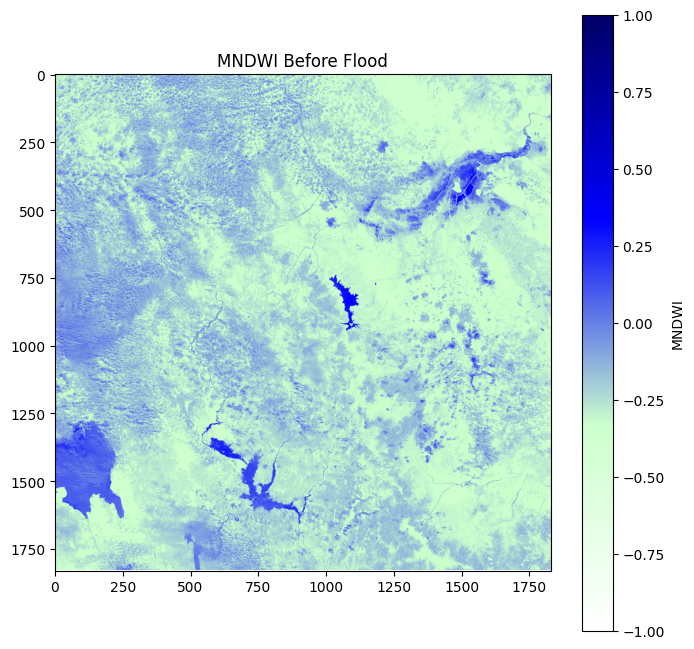

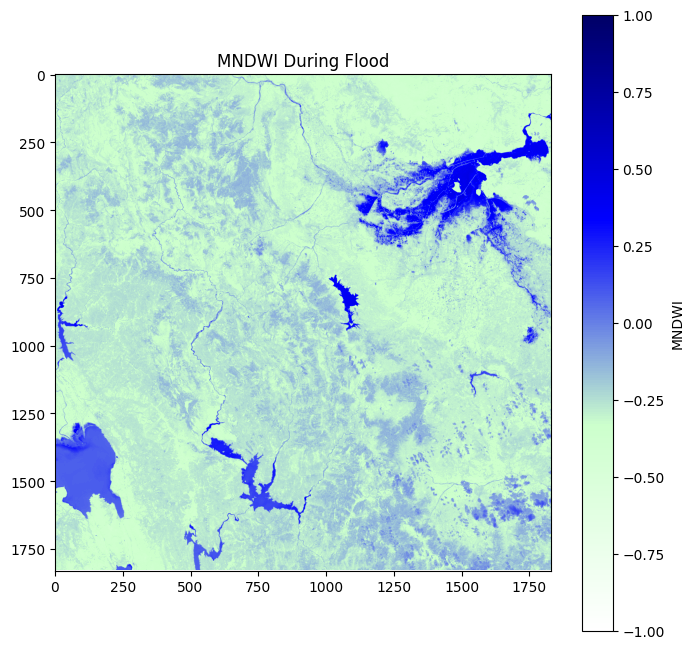

In [8]:
# Define a colormap that transitions from white to light green to blue to dark navy blue
colors = [(1, 1, 1), (0.8, 1, 0.8), (0, 0, 1), (0, 0, 0.4)]  # (R, G, B)
cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)

# Create a figure and axis for the MNDWI before flood (mndwi_b) raster
plt.figure(figsize=(8, 8))
plt.imshow(mndwi_b, cmap=cmap, vmin=-1, vmax=1)  # Adjust the colormap and limits as needed
plt.colorbar(label='MNDWI')
plt.title('MNDWI Before Flood')

# Create a figure and axis for the MNDWI during flood (mndwi_f) raster
plt.figure(figsize=(8, 8))
plt.imshow(mndwi_f, cmap=cmap, vmin=-1, vmax=1)  # Adjust the colormap and limits as needed
plt.colorbar(label='MNDWI')
plt.title('MNDWI During Flood')

plt.show()


In [9]:
#Create mask by SCL values
mask_f = np.logical_or(scl_f == 8, np.logical_or(scl_f == 9, scl_f == 3))
mask_b = np.logical_or(scl_b == 8, np.logical_or(scl_b == 9, scl_b == 3))
#Calculate difference between flood period and normal period
diff = mndwi_f - mndwi_b

#Calculate water tides by showing the pixcels that have positive difference values
tide = diff
tide[(diff < 0)] = 0
tide[mask_f | mask_b] = 0
tide = tide / tide.max()
#Calculate flood areas by showing the pixcels that have possitive difference values and had negative values of MNDWI before flood
flood = diff
flood[(diff < 0) | (mndwi_b > 0)] = 0
flood[mask_f | mask_b] = 0
flood = flood / flood.max()


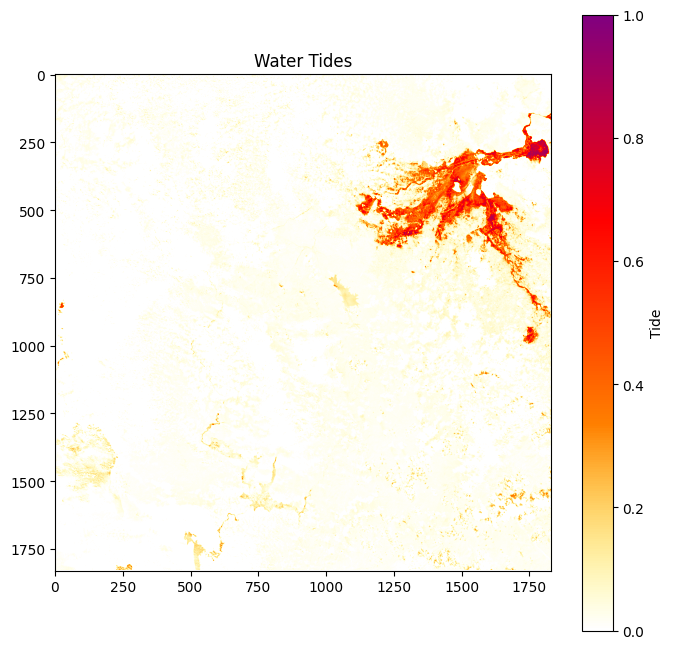

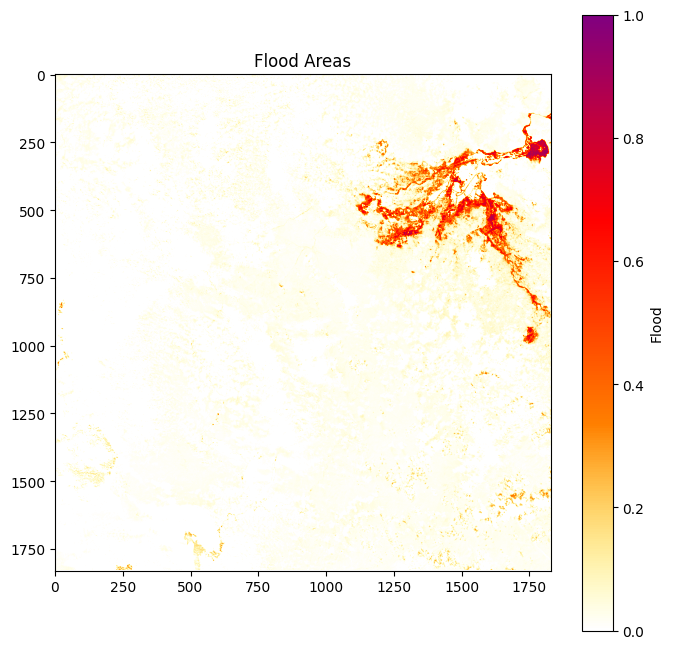

In [10]:
# Define a colormap that goes from yellow to red with transparency for 0 values and violet for high values
colors = [(1, 1, 0, 0), (1, 0.5, 0, 1), (1, 0, 0, 1), (0.5, 0, 0.5, 1)]  # (R, G, B, Alpha)
cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)

# Create a figure and axis for the Water Tides raster
plt.figure(figsize=(8, 8))
plt.imshow(tide, cmap=cmap, vmin=0, vmax=np.max(tide))  # Adjust the colormap and limits as needed
plt.colorbar(label='Tide')
plt.title('Water Tides')

# Create a figure and axis for the Flood Areas raster
plt.figure(figsize=(8, 8))
plt.imshow(flood, cmap=cmap, vmin=0, vmax=np.max(flood))  # Adjust the colormap and limits as needed
plt.colorbar(label='Flood')
plt.title('Flood Areas')

plt.show()


In [11]:
def save(raster, name):
    with rasterio.open(f"{name}.tif", 'w', driver='GTiff', width=raster.shape[1], height=raster.shape[0], count=1, dtype=raster.dtype, crs=crs, transform=transform) as dst:
        dst.write(raster, 1)


In [12]:
save(mndwi_b, 'mndwi_before_greece')
save(mndwi_f, 'mndwi_flood_greece')
save(tide, 'tide_greece')
save(flood, 'flood_greece')
